In [1]:
%pip install shapely

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:01:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import shapely.geometry as sh
import numpy as np

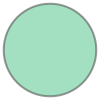

In [62]:
log = sh.Point(0,0).buffer(30)
log

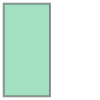

In [63]:
plank = sh.box(0, 0, 10, 20)
plank

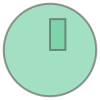

In [64]:
sh.GeometryCollection([log, plank])

# Kodowanie
czwórki: x1, y1, width, height

preferowalnie trzymane jako obiekty `shapely` podczas uczenia

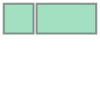

In [45]:
chromo = np.array([0., 0., 10., 10., 11., 0., 20., 10.])

def single_to_box(single):
    return sh.box(single[0], single[1], single[0] + single[2], single[1] + single[3])

def multiple_to_box(mult):
    return [
        single_to_box(single)
        for single in 
        np.split(mult, len(mult)//4)
    ]

sh.GeometryCollection(multiple_to_box(chromo))

In [49]:
reverse = single_to_box((0., 3., 10., 10.))
def box_to_single(box):
    return np.array([
        box.bounds[0],
        box.bounds[1],
        box.bounds[2] - box.bounds[0],
        box.bounds[3] - box.bounds[1]
    ])
box_to_single(reverse)

array([ 0.,  3., 10., 10.])

# Krzyżowanie
1. Parowanie osobników
2. Połączenie wszystkich elementów (desek) w jedną pulę
3. Losowy wybór elementu z puli
4. Sprawdzenie czy dodany element nie inwaliduje potomka 
5. Jeżeli nie, to dodanie elementu do potomka
6. Pętla do 3. dopóki nie skończą się elementy w puli

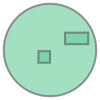

In [77]:
chromo1 = np.array([-10., -11., 10., 10., 13., 5., 20., 10.])
chromo2 = np.array([-11., 0., 10., 10., 11., 0., 20., 10.])
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1)
))

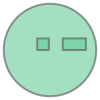

In [78]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo2)
))

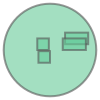

In [286]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1),
    *multiple_to_box(chromo2)
))

In [79]:
pool = [*multiple_to_box(chromo1), *multiple_to_box(chromo2)]
new_specimen = []
new_specimen_multipoly = sh.MultiPolygon()

In [80]:
for el in pool:
    if not new_specimen_multipoly.intersects(el):
        new_specimen.append(el)
        new_specimen_multipoly = new_specimen_multipoly.union(el)

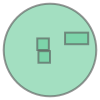

In [81]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *new_specimen
))

# Selekcja
Ruletka *fitness proportionate* z 5-10% elitaryzmem.

# Mutacje

## Przesunięcie
Dodanie gaussowskiego szumu do lokalizacji $n$ elementów.
Jeżeli przecina inny element, to:
* jest usuwana z pstwem $p$
* do oryginału jest dodawane mniej szumu z pstwem $q$
* z prawdopodobieństwem $1-p-q$ mutacja jest anulowana.

In [117]:
chromo1 

array([-10., -11.,  10.,  10.,  13.,   5.,  20.,  10.])

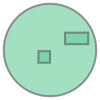

In [129]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1)
))

In [130]:
chromo_mut = chromo1 + np.concatenate((
    np.random.normal(5, size=2),
    np.zeros(6)
))

In [131]:
chromo_mut

array([-5.04253761, -5.38746299, 10.        , 10.        , 13.        ,
        5.        , 20.        , 10.        ])

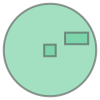

In [266]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo_mut)
))

## Dodawanie
dodanie losowego elementu 
przeprowadza $n$ prób dodania w losoych koordynatach

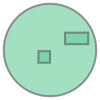

In [267]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1)
))

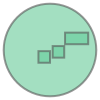

In [265]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1),
     single_to_box(
         np.concatenate((
         np.random.normal(0, 10, size=2),
         np.array([10,10])
        ))
     )
))

In [ ]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *multiple_to_box(chromo1)
))

## Dopasowanie?
nie wiem do końca jak zrobić i czy ma sens

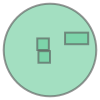

In [133]:
sh.GeometryCollection((
    sh.Point((0, 0)).buffer(40),
    *new_specimen
))

In [279]:
a = sh.MultiPolygon((new_specimen[0], new_specimen[2]))
bind_point = np.array(op.nearest_points(a.buffer(0.01), new_specimen[1])[0].bounds[0:2])
bind_point

array([-0.99, 10.  ])

In [280]:
[
    el.wkt for el in 
    op.nearest_points(a.buffer(0.01), new_specimen[1])
]

['POINT (-0.99 10)', 'POINT (13 10)']

In [281]:
snapped = single_to_box(
    np.concatenate((
        bind_point,
        box_to_single(new_specimen[1])[2:4]
    ))
)

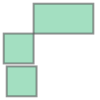

In [283]:
sh.MultiPolygon((
    new_specimen[0],
    snapped,
    new_specimen[2]
    
))

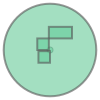

In [284]:
sh.GeometryCollection((
    sh.Point((0, 0)),
    sh.Point((0, 0)).buffer(40),
    new_specimen[0],
    snapped,
    new_specimen[2]
    
))